# Project: WeRateDogs Data wrangling, analyzing and visualizing

## 1. Introduction

**WeRateDogs** is a Twitter account that rates people's dogs with a humorous comment about the dog. The account was started in 2015 by college student Matt Nelson, and has received international media attention both for its popularity. The dataset that we shall be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

Below are are some definition of some characteristics of dog:

<image src = dogtionary-combined.png>

## 2. Project Context

To wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

## 3. Project Steps Overview
Our tasks in this project are as follows:

        Step 1: Gathering data

        Step 2: Assessing data

        Step 3: Cleaning data

        Step 4: Storing data

        Step 5: Analyzing, and visualizing data

        Step 6: Reporting

            * the data wrangling efforts
            * the data analyses and visualizations

## 4. Data relevance

In this project, we shall work on the following three datasets.

**i). Enhanced Twitter Archive**

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

**ii). Image predictions File**

This file (image_predictions.tsv) is present in each tweet according to a neural network. It is hosted on Udacity's servers and will be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

**iii). Twitter API**

We shall also use Twitter API to get additional data for the Project

## 3. Importing the Libraries for the Project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
import configparser
import sqlite3
pd.set_option('display.max_columns', None)
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image,ImageFont

## 4. Gathering the Data

### i). Archive Twitter dataset

In [59]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv', sep=',')

In [60]:
# Checking the dataframe

twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### ii). Image Prediction File dataset

In [61]:
from urllib import response


url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

In [62]:
response

<Response [200]>

In [63]:
open('image-predictions.tsv', 'wb').write(response.content)

335079

In [64]:
# Accessing the  file

twitter_image_pred = pd.read_csv('image-predictions.tsv', sep='\t')

In [65]:
# Checking the dataframe

twitter_image_pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### iii). Twitter API

In [9]:
import config

In [10]:
api_key = config.twitter_api['api_key']
api_key_secret = config.twitter_api['api_key_secret']
access_token = config.twitter_api['access_token']
access_token_secret = config.twitter_api['access_token_secret']

In [11]:
# Authenticating the APIs
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

# Creating the API object and parsing the result to JSON object
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [62]:
# Obtaining the tweets from  @dog_rates handle

user = 'dog_rates'


# Creating a dataframe from the tweets

data = [] # List  to store our tweet data
error = [] # List to store errors

for tweet_id in twitter_archive.tweet_id:
    try:
        page = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        
        retweet_count = page['retweet_count']
        favorite_count = page['favorite_count']
        date_time = page['created_at']
        
        data.append({'tweet_id': int(tweet_id),
                        'retweet_count': int(retweet_count),
                        'favorite_count': int(favorite_count),                        
                        'date_time': pd.to_datetime(date_time)})
        
# the errors
    except tweepy.TweepError as e:
        print(str(tweet_id) + ': ' + str(e))
        error.append(tweet_id)
        

888202515573088257: [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921: [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937: [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745: [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329: [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744: [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320: [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130: [{'code': 144, 'message': 'No status found with that ID.'}]
856330835276025856: [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560: [{'code': 144, 'message': 'No status found with that ID.'}]
851861385021730816: [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705: [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984: [{'code': 144, 'mess

Rate limit reached. Sleeping for: 65


827228250799742977: [{'code': 144, 'message': 'No status found with that ID.'}]
812747805718642688: [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832: [{'code': 144, 'message': 'No status found with that ID.'}]
779123168116150273: [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464: [{'code': 144, 'message': 'No status found with that ID.'}]
771004394259247104: [{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
770743923962707968: [{'code': 144, 'message': 'No status found with that ID.'}]
766864461642756096: [{'code': 144, 'message': 'No status found with that ID.'}]
759923798737051648: [{'code': 144, 'message': 'No status found with that ID.'}]
759566828574212096: [{'code': 144, 'message': 'No status found with that ID.'}]
754011816964026368: [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 81


680055455951884288: [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 106


In [70]:
# Storing the data to tweet_json.txt

tweet_json = pd.DataFrame(data, columns=['tweet_id', 'retweet_count', 'favorite_count', 'date_time'])

tweet_json.to_json('tweet_json.txt')

In [164]:
# Reading the json from the txt file

with open('tweet_json.txt') as json_file:
    data = json.load(json_file)

In [66]:
# Creating a dataframe from the json file

tweets_api_df = pd.read_json('tweet_json.txt')

tweets_api_df.head(3)

,tweet_id,retweet_count,favorite_count,date_time
0,892420643555336193,6979,33728,2017-08-01 16:23:56
1,892177421306343426,5280,29256,2017-08-01 00:17:27
2,891815181378084864,3466,21987,2017-07-31 00:18:03


## 5. Accessing the Dataset

### i). Archive Twitter Dataset

In [31]:
# Checking the top and bottom rows of the dataframe
# Top

twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [32]:
# Bottom

twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [29]:
# Checking the information about the dataframe

twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
# Checking  for missing values

total = twitter_archive.isnull().sum().sort_values(ascending=False)
percentage = (twitter_archive.isnull().sum()/twitter_archive.isnull().count()).sort_values(ascending=False)
missing_value = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_value.head(10)

,Total,Percentage
in_reply_to_user_id,2278,0.966893
in_reply_to_status_id,2278,0.966893
retweeted_status_timestamp,2175,0.923175
retweeted_status_id,2175,0.923175
retweeted_status_user_id,2175,0.923175
expanded_urls,59,0.025042
rating_denominator,0,0.000000
pupper,0,0.000000
floofer,0,0.000000
doggo,0,0.000000


In [14]:
# Checking for duplicate rows

twitter_archive.duplicated().sum()

0

In [15]:
# Checking the names of the dogs

twitter_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [165]:
# Checking using value_counts()

twitter_archive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Toby         7
an           7
Bailey       7
Leo          6
Oscar        6
Name: name, dtype: int64

### ii). Image Prediction File dataset

In [78]:
# Checking the information about the dataframe

twitter_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [79]:
# Checking for missing values

total = twitter_image_pred.isnull().sum().sort_values(ascending=False)
percentage = (twitter_image_pred.isnull().sum()/twitter_image_pred.isnull().count()).sort_values(ascending=False)
missing_value = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_value.head(10)

,Total,Percentage
tweet_id,0,0.0
jpg_url,0,0.0
img_num,0,0.0
p1,0,0.0
p1_conf,0,0.0
p1_dog,0,0.0
p2,0,0.0
p2_conf,0,0.0
p2_dog,0,0.0
p3,0,0.0


In [80]:
# Checking the duplicates

twitter_image_pred.duplicated().sum()

0

In [19]:
twitter_image_pred.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [22]:
# Checking unique values in column p1

twitter_image_pred.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama',
       'Chesapeake_Bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'Ibizan_hound', 'Border_collie', 'Labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'Airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 't

### iii). Twitter API

In [82]:
# Checking information about the dataframe

tweets_api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        2327 non-null   int64         
 1   retweet_count   2327 non-null   int64         
 2   favorite_count  2327 non-null   int64         
 3   date_time       2327 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 90.9 KB


In [83]:
# Checking for missing values

total = tweets_api_df.isnull().sum().sort_values(ascending=False)
percentage = (tweets_api_df.isnull().sum()/tweets_api_df.isnull().count()).sort_values(ascending=False)
missing_value = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_value.head(10)

,Total,Percentage
tweet_id,0,0.0
retweet_count,0,0.0
favorite_count,0,0.0
date_time,0,0.0


In [84]:
# Checking for duplicates

tweets_api_df.duplicated().sum()

0

### Quality issues

#### i). Archive Twitter Dataset

1.  We are interested with the original tweets only and not including retweets.
2.  We have so many missing values in the 'in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id' and 'retweeted_status_timestamp' columns
2.  The 'timestamp' column is in object datatype instead of date_time.
4.  We have so many dogs without names and also improper names like 'a','an', 'the','just', etc
5.  'tweet_id' column is supposed to be of string datatype since we are not planning to do any arithmetic
     operations on it.


#### ii). Image Prediction File dataset

6.    The p1, p2 and p3 columns have both upper and lower cases for the individual records. 
7.    We have some false predictions for the dogs.
8.    The 'tweet_id' column is supposed to be of string datatype since we are not planning to do any arithmetic
     operations on it.|


#### iii). Twitter API

9.   The 'tweet_id' column is supposed to be of string datatype since we are not planning to do any arithmetic
     operations on it.

### Tidiness Issues

1.  The columns 'doggo', 'floofer', 'pupper' and 'puppo' in the twitter_archive dataframe can be reshaped to one column to avoid redundancy using melt.
2.  Columns in the twitter_image_predictions dataframe are not in format that can easily be understood by a human.
2.  The twitter_archive dataframe and twitter_api_df dataframe can be merged for easy analysis.

## 6. Cleaning Data

In [67]:
# Making copies of the original datasets

twitter_archive_clean = twitter_archive.copy()
twitter_image_clean = twitter_image_pred.copy()
tweets_api_clean = tweets_api_df.copy()

### Quality

#### Issue 1:

##### Define

We are interested with the original tweets only and not including retweets. Therefore we shall drop all the row containing values at 'retweeted_status_id'

##### Code

In [68]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

##### Test

In [69]:
# Checking to confirm the retweeted_status_id is null

twitter_archive_clean.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

#### Issue 2:

##### Define

We have so many missing values in the 'in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id' and 'retweeted_status_timestamp' columns. Since we are not using the columns for the analysis, we shall proceed to drop the columns except the 'expanded_urls' since the column does not have so many missing values and it is relevant to the analysis

##### Code

In [70]:
columns_to_drop  = ['in_reply_to_status_id','in_reply_to_user_id',
                    'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']

twitter_archive_clean.drop(columns_to_drop, axis=1, inplace=True)

In [71]:
# We shall drop the null values in the 'expanded_url' column

twitter_archive_clean.dropna(inplace=True)

##### Test

In [72]:
# Checking the nulls

twitter_archive_clean.isnull().sum().sum()

0

#### Issue 3:

##### Define

The 'timestamp' column is in object datatype instead of date_time. We shall be converting them to date_time datatype

##### Code

In [73]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

##### Test

In [74]:
# Checking the result

twitter_archive_clean.timestamp.dtype

datetime64[ns, UTC]

#### Issue 4.

#### Define

We have so many dogs without names and also improper names like 'a','an', 'the','just', etc  If we visually check the names, we can note that any name of the  dog with the above articles start with small letters. Therefore, we shall be changing all names with lower case to 'None' for consistency. 

#### Code

In [75]:
# We shall assign all the values having lower letters to None
twitter_archive_clean.loc[twitter_archive_clean.name.str.islower(), 'name'] = None

# We shall then replace the None with nan
twitter_archive_clean.name.replace(regex = r'None', value = np.nan, inplace = True)

#### Test

In [76]:
twitter_archive_clean.name.value_counts().head(10)

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Penny       9
Tucker      9
Sadie       8
Lola        8
Winston     8
Toby        7
Name: name, dtype: int64

#### Issue 5.

#### Define

'tweet_id' column is supposed to be of string datatype since we are not planning to do any arithmetic operations on it. We shall convert it to string datatype.

#### Code

In [77]:
# Converting 'tweet_id' in the three datasets to  strings

twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')
twitter_image_clean['tweet_id'] = twitter_image_clean['tweet_id'].astype('str')
tweets_api_clean['tweet_id'] = tweets_api_clean['tweet_id'].astype('str')

#### Test

In [78]:
print(twitter_archive_clean.tweet_id.dtype)
print(twitter_image_clean.tweet_id.dtype)
print(tweets_api_clean.tweet_id.dtype)

object
object
object


#### Issue 6.

#### Define

The p1, p2 and p3 columns have both upper and lower cases for the individual records. We shall capitalize the names for consistency. 

#### Code

In [79]:
twitter_image_clean.p1 = twitter_image_clean.p1.str.capitalize()
twitter_image_clean.p2 = twitter_image_clean.p2.str.capitalize()
twitter_image_clean.p3 = twitter_image_clean.p3.str.capitalize()

#### Test

In [80]:
twitter_image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Issue 7.

#### Define

We have some false predictions for the dogs. We shall drop the rows with false predictions.

#### Code

In [81]:
# Selecting false predictions and Displaying few columns with the false predictions of dogs in the three columns p1,p2 and p3

false_predictions = twitter_image_clean[(twitter_image_clean.p1_dog == False) & (twitter_image_clean.p2_dog == False) & (twitter_image_clean.p3_dog == False)]
false_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,Box_turtle,0.933012,False,Mud_turtle,0.045885,False,Terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,Hen,0.965932,False,Cock,0.033919,False,Partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,Desktop_computer,0.086502,False,Desk,0.085547,False,Bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,Three-toed_sloth,0.914671,False,Otter,0.015250,False,Great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,Guinea_pig,0.996496,False,Skunk,0.002402,False,Hamster,0.000461,False


In [82]:
# Dropping the false predictions from the three datasets

twitter_image_clean = twitter_image_clean[~twitter_image_clean.isin(false_predictions).dropna(how='all')]

#### Test

In [83]:
check = false_predictions = twitter_image_clean[(twitter_image_clean.p1_dog == False) & (twitter_image_clean.p2_dog == False) & (twitter_image_clean.p3_dog == False)]
check

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Issue 8.

#### Define

The 'tweet_id' column in the 'twitter_image_prediction' is supposed to be of string datatype since we are not planning to do any arithmetic operations on it.

#### Code

In [84]:
twitter_image_clean.tweet_id = twitter_image_clean.tweet_id.astype('str')

#### Test

In [85]:
print(twitter_image_clean.tweet_id.dtypes)

object


#### Issue 9.

#### Define

The 'tweet_id' column in the 'tweet_api' dataset is supposed to be of string datatype since we are not planning to do any arithmetic operations on it.

#### Code

In [86]:
tweets_api_clean.tweet_id = tweets_api_clean.tweet_id.astype('str')

#### Test

In [87]:
print(tweets_api_clean.tweet_id.dtypes)

object


### Tidiness

#### Issue 1.

#### Define

The columns 'doggo', 'floofer', 'pupper' and 'puppo' in the twitter_archive dataframe can be reshaped to one column to avoid redundancy using melt.

#### Code

In [88]:
# We shall melt to columns 'doggo', 'floofer', 'pupper' and 'puppo'

twitter_archive_clean = twitter_archive_clean.melt(id_vars=['tweet_id','timestamp','source','text','expanded_urls','rating_numerator','rating_denominator','name'],
                           value_vars=['doggo','floofer','pupper','puppo'], var_name='dog_type', value_name='dog_present')

In [92]:
# Dropping the None values in the 'dog_present' column

twitter_archive_clean.dog_present = twitter_archive_clean.dog_present.map(lambda x: x.replace("None",""))

#### Test

In [93]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,dog_present
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,doggo,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,doggo,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,doggo,
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,doggo,
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,doggo,


#### Issue 2.

#### Define

Columns in the twitter_image_predictions dataframe are not in format that can easily be understood by a human. We shall rename the columns.

#### Code

In [94]:
new_columns = ['tweet_id', 'jpg_url', 'img_num', 'prediction_one', 'prediction_one_confidence', 'dog_breed_one', 'prediction_two',
       'prediction_two_confidence', 'dog_breed_two', 'prediction_three', 'prediction_three_confidence', 'dog_breed_three']

# Renaming the columns

twitter_image_clean.columns = new_columns

#### Test

In [95]:
twitter_image_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_one',
       'prediction_one_confidence', 'dog_breed_one', 'prediction_two',
       'prediction_two_confidence', 'dog_breed_two', 'prediction_three',
       'prediction_three_confidence', 'dog_breed_three'],
      dtype='object')

#### Issue 3.

#### Define

The twitter_archive dataframe,twitter_image_prediction and twitter_api_df dataframe can be merged for easy analysis.

#### Code

In [96]:
twitter_df = twitter_archive_clean.merge(twitter_image_clean, on='tweet_id')

twitter_df = twitter_df.merge(tweets_api_clean, on='tweet_id')

#### Test

In [97]:
twitter_df.shape

(6712, 24)

In [98]:
# Checking the the dataframe

twitter_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,dog_present,jpg_url,img_num,prediction_one,prediction_one_confidence,dog_breed_one,prediction_two,prediction_two_confidence,dog_breed_two,prediction_three,prediction_three_confidence,dog_breed_three,retweet_count,favorite_count,date_time
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,doggo,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,5280,29256,2017-08-01 00:17:27
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,floofer,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,5280,29256,2017-08-01 00:17:27
2,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,pupper,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,5280,29256,2017-08-01 00:17:27
3,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,puppo,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,5280,29256,2017-08-01 00:17:27
4,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,doggo,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,3466,21987,2017-07-31 00:18:03


In [99]:
# Cleaning the final dataframe

In [100]:
# Removing of missing values

twitter_df.dropna(inplace=True)

In [101]:
# Dropping the duplicates

twitter_df.drop_duplicates(inplace=True)

In [102]:
# Dropping the date_time column since we have timestamp column  

twitter_df.drop(['date_time'], axis=1, inplace=True)

## 7. Storing the Data

In [103]:
# We shall save the final dataframe in a csv file by the name 'twitter_archive_master.csv'

twitter_df.to_csv('twitter_archive_master.csv', index=False)

In [104]:
# We shall also store the data in the SQLite database

# Installing the  ipython-sql library
# !pip install ipython-sql

In [4]:
# Creating the connection to the database   

connection = sqlite3.connect('twitter_archive_master.db')

In [106]:
# Adding the dataframe to the database

twitter_df.to_sql('twitter_archive_master', connection, if_exists='replace', index=False)

## 8. Analyzing and Visualizing Data

In [5]:
# Importing the dataset from the database

twitter_archive_master = pd.read_sql_query("SELECT * FROM twitter_archive_master", connection)

# Previewing the dataframe

twitter_archive_master.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,dog_present,jpg_url,img_num,prediction_one,prediction_one_confidence,dog_breed_one,prediction_two,prediction_two_confidence,dog_breed_two,prediction_three,prediction_three_confidence,dog_breed_three,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,doggo,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,1,Pekinese,0.090647,1,Papillon,0.068957,1,5280,29256
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,floofer,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,1,Pekinese,0.090647,1,Papillon,0.068957,1,5280,29256
2,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,pupper,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,1,Pekinese,0.090647,1,Papillon,0.068957,1,5280,29256


### Insights

#### Insights 1: What is the most popular dog breed as per the predictions?

In [120]:
# Predicting one

twitter_archive_master.prediction_one.value_counts().head(10)

Golden_retriever      368
Pembroke              256
Labrador_retriever    248
Chihuahua             236
Pug                   156
Chow                  124
Toy_poodle            108
Pomeranian            104
Malamute               88
Samoyed                88
Name: prediction_one, dtype: int64

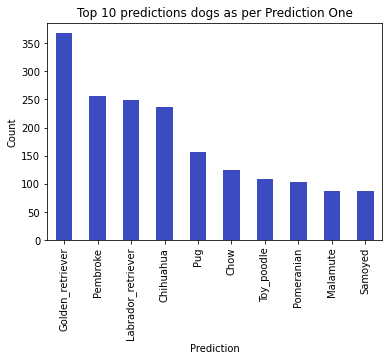

In [229]:
# Visualizing top the prediction one

twitter_archive_master.prediction_one.value_counts().head(10).plot(kind='bar',cmap='coolwarm')
plt.title('Top 10 predictions dogs as per Prediction One')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

In [121]:
# Predicting two

twitter_archive_master.prediction_two.value_counts().head(10)

Labrador_retriever          260
Golden_retriever            236
Cardigan                    212
French_bulldog              116
Chihuahua                   108
Pomeranian                  108
Toy_poodle                  108
Chesapeake_bay_retriever    108
Miniature_poodle             96
Pembroke                     92
Name: prediction_two, dtype: int64

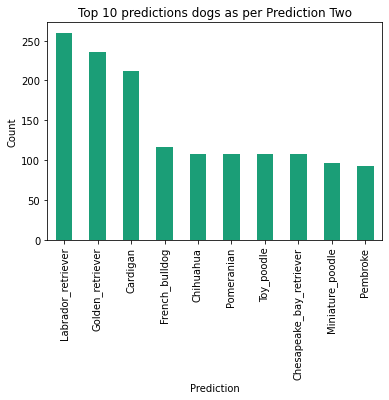

In [230]:
# Visualizing top the prediction two

twitter_archive_master.prediction_two.value_counts().head(10).plot(kind='bar',cmap='Dark2')
plt.title('Top 10 predictions dogs as per Prediction Two')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

In [122]:
# Predicting three

twitter_archive_master.prediction_three.value_counts().head(10)

Labrador_retriever    224
Chihuahua             164
Golden_retriever      112
Kelpie                112
Chow                  100
Toy_poodle             92
Beagle                 92
Eskimo_dog             88
Pembroke               88
Malamute               88
Name: prediction_three, dtype: int64

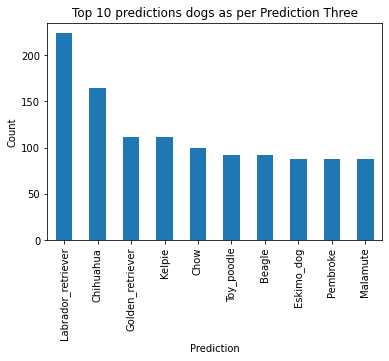

In [231]:
# Visualizing top the prediction three

twitter_archive_master.prediction_three.value_counts().head(10).plot(kind='bar')
plt.title('Top 10 predictions dogs as per Prediction Three')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

**We can clear see from the three predictions that Golden_retriever, Labrador_retriever and Chihuahua are the most popular dog breeds.**

#### Insights 2: Is there a corelation between Retweets and Favorites?

In [47]:
# Calculating the correlation between retweet_count and favorite_count

corr = twitter_archive_master[['retweet_count','favorite_count']].corr()

print(f'The correlation between retweet_count and favorite_count is {corr["retweet_count"]["favorite_count"]}')

The correlation between retweet_count and favorite_count is 0.9248637184158763


#### Visualizing of Insights 2

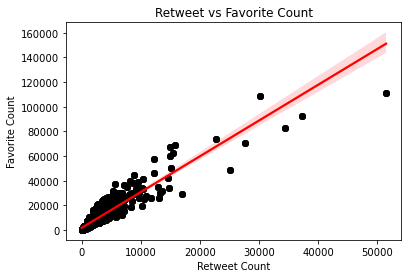

In [46]:
sns.regplot(x='retweet_count', y='favorite_count', data=twitter_archive_master,
            scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title('Retweet vs Favorite Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.show()

**We can clearly see that there is a strong corelation between retweets and favorites.**

#### Insights 3: What is the average numerator ratings for the dogs?

In [206]:
twitter_archive_master.rating_numerator.mean()

10.994915254237288

In [7]:
twitter_archive_master.rating_numerator.describe()

count    4720.000000
mean       10.994915
std         2.822723
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        75.000000
Name: rating_numerator, dtype: float64

**We have an average numerator rating of 10.99 for the dogs.**

#### Insights 4: What are the most popular words in the tweets text?

In [140]:
# Creating a Function using regex to clean the tweets texts further for the analysis

def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9_]+','',str(text)) # Removing @mentions
  text = re.sub(r'#','',str(text)) # Removing the '#' symbol
  text = re.sub(r'RT[\s]+','',str(text))  # Removing RT
  text = re.sub(r'https?:\/\/\S+', '',str(text)) # Removing the hyper link
  text = re.sub(r':', '',str(text)) # Removing the ':'
  text = re.sub(r';', '',str(text)) # Removing the ';'
  text = re.sub(r'\n', '',str(text)) # Removing the '\n'
  text = re.sub(r'1', '',str(text)) # Removing the '1'
  text = re.sub(r'_', '',str(text)) # Removing the '1'

  return text

twitter_archive_master['text'] = twitter_archive_master['text'].apply(cleanTxt)

# Showing cleaned text

twitter_archive_master.text.head()

0    This is Tilly. She's just checking pup on you....
1    This is Tilly. She's just checking pup on you....
2    This is Tilly. She's just checking pup on you....
3    This is Tilly. She's just checking pup on you....
4    This is Archie. He is a rare Norwegian Pouncin...
Name: text, dtype: object

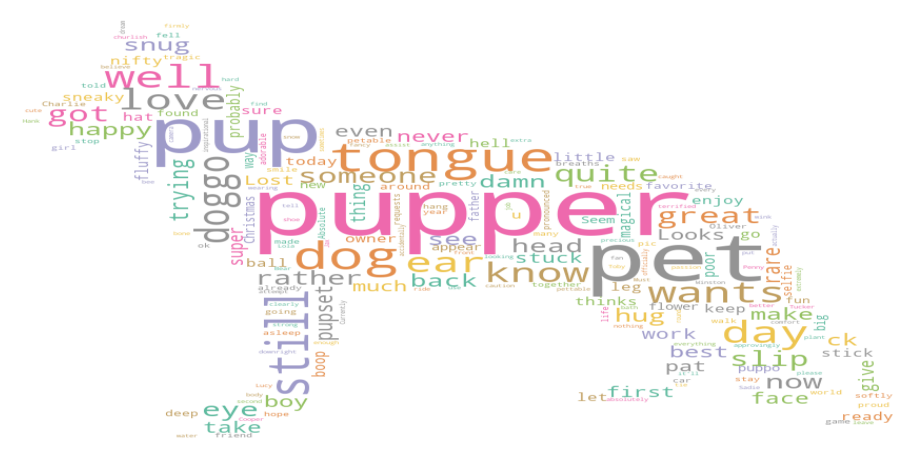

In [209]:
# Plotting Word Cloud 

stopwords = ['one','need','hello','look','meet','think','amp','good','likes','tho','say','really',
             'will','af','ckin','want','help','always','time','h'] + list(STOPWORDS)

mask = np.array(Image.open("german_shepherd.png"))

allWords = ' '.join([twts for twts in twitter_archive_master['text']])

wordCloud = WordCloud(width = 1000, height = 600, random_state = 67, max_font_size = 119,mask=mask,
                      background_color="white",stopwords = stopwords, collocations=False,colormap='Dark2').generate(allWords)

plt.figure(figsize = (16,8))
plt.imshow(wordCloud, interpolation = 'bilinear', aspect = 'auto', alpha = 0.7)
plt.axis('off')
plt.show()

**From the above wordcloud, we can clearlly the the name Pupper is popular in most of the tweets.**